# Open Street Map Data Wrangling - MongoDB

## About

This analysis investigated the Open Street Map XML dataset for the city of South Bend, Indiana, which is the home of the University of Notre Dame (my alma mater). This dataset was parsed, cleaned, converted into JSON format, and imported into a MongoDB database. The following data cleaning was conducted: 1.) street names, 2.) street abbreviations, 3.) zip codes, 4.) county names, and 5.) road surfaces. Lastly, the database was queried for nodes (points in space), ways (linear features and boundaries), users, schools, hospitals, zip codes, bicycle lanes, amenities, and University of Notre Dame. 

## Methods 

### Data Source (downloaded 1/28/2016)

Dataset: https://s3.amazonaws.com/metro-extracts.mapzen.com/south-bend_indiana.osm.bz2     
Website: https://mapzen.com/data/metro-extractsic/data

### Hardware and Software Versions 

Software: Python 2.7.11 (Anaconda 2.5.0), MongoDB 3.2     
Operating System: Mac OS X 10.11.2     
Hardware: Intel Core 2 Duo 2.4 GHz, 4 GB RAM     

### File Information

XML Data: data-south-bend-indiana.osm = 64.6 MB     
JSON Data: data-south-bend-indiana.osm.json = 72.4 MB      
Reference Code: open-street map-case-study-problems.py 

### Python Libraries 

In [2]:
import numpy as np
import pandas as pd
import xml.etree.cElementTree as ET
import matplotlib.pyplot as plt
import pprint
import re
import codecs
import json
import os
from collections import defaultdict

## Import Data

Data was imported and briefly investigated for number/types of tags and top contributing users. 

In [3]:
# input xml file, open street map (south bend, IN)
file_in = 'data-south-bend-indiana.osm'

In [4]:
# count number of tags
# source: modified code from udacity case study
info = {}
for _ , element in ET.iterparse(file_in):
    info[element.tag] = info.get(element.tag, 0) + 1
pprint.pprint(info)

{'bounds': 1,
 'member': 1881,
 'nd': 341194,
 'node': 286873,
 'osm': 1,
 'relation': 204,
 'tag': 193800,
 'way': 31575}


In [5]:
# function that outputs top users
# source: modified code from udacity case study
def top_users(filename):
    users = []
    for _ , element in ET.iterparse(filename):
        try:
            user = element.attrib['uid']
            users.append(user)
        except:
            pass
    names = []
    for _ , element in ET.iterparse(filename):
        try:
            name = element.attrib['user']
            names.append(name)
        except:
            pass
    return users,names

In [6]:
# top users
pd.Series( top_users(file_in)[1] ).value_counts().head(10)

woodpeck_fixbot    88531
cassini83          85818
athalon012         33477
Tom Layo           17772
TIGERcnl            9196
bot-mode            6721
jonesydesign        6081
LinuxScribe         5555
WhitePlume          4893
maxerickson         3927
dtype: int64

## Clean Data

### 1. Street Names

The dataset was investigated for inconsistencies/errors in street names (addr:street and name tags). Some tags were found to use full street name types (i.e. Street, Avenue, etc.) while others used abbreviations (i.e. St., Ave., etc.). A mapping was created to convert the inconsistent values to full street name types. 

In [7]:
# CLEAN DATA STEP 1: clean street names in "addr:street" and "name" tags 
# source: modified code from udacity case study
street_type_re = re.compile(r'\b\S+\.?$', re.IGNORECASE)
expected = ["Street", "Avenue", "Boulevard", "Drive", "Court", "Place", 
            "Square", "Lane", "Road", "Trail", "Parkway", "Commons",
            "Circle", "Way", "Highway", "Cove", "Crossing", "Bend"
            "North", "South", "East", "West", "Ridge", "Run", "Trace"]
mapping_street_name = { "Ave": "Avenue", "Blvd": "Boulevard",
                        "Blvd." : "Boulevard","Dr" : "Drive",
                        "Pky" : "Parkway", "Rd" : "Road",
                        "St" : "Street", "Ln" : "Lane",
                        "Cir" : "Circle", "Crt" : "Court", 
                        "Ct" : "Court", "Tr" : "Trail", 
                        "Trl" : "Trail" }

In [8]:
# function to audit street names
# source: modified code from udacity case study
def audit_street_name(osmfile):
    osm_file = open(osmfile, "r")
    street_types = defaultdict(set)
    for event, elem in ET.iterparse(osm_file, events=("start",)):
        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_street_name(tag):
                    audit_street_type(street_types, tag.attrib['v'])
    return street_types

In [9]:
# function to test if tag is a street name
# source: modified code from udacity case study
def is_street_name(elem):
    return ( (elem.attrib['k'] == "addr:street") or (elem.attrib['k'] == "name") )

In [10]:
# function that compares acutal street names to the expected
# source: modified code from udacity case study
def audit_street_type(street_types, street_name):
    m = street_type_re.search(street_name)
    if m:
        street_type = m.group()
        if street_type not in expected:
            street_types[street_type].add(street_name)

In [11]:
# display possible street name errors to fix
st_types = audit_street_name(file_in)
pprint.pprint(dict(st_types))

{'1': set(['1', 'County Road 1', 'Pavilion 1']),
 '10': set(['County Road 10']),
 '100': set(['100', 'County Road 100']),
 '101': set(['County Road 101']),
 '102': set(['County Road 102']),
 '103': set(['County Road 103', 'Old M 103']),
 '104': set(['104', 'County Road 104']),
 '105': set(['County Road 105']),
 '106': set(['County Road 106']),
 '107': set(['County Road 107']),
 '108': set(['County Road 108']),
 '109': set(['County Road 109']),
 '11': set(['County Road 11', "Martin's SuperMarket #11"]),
 '110': set(['110']),
 '111': set(['County Road 111']),
 '112': set(['County Road 112', 'Old 112']),
 '113': set(['County Road 113']),
 '115': set(['County Road 115']),
 '116': set(['116']),
 '117': set(['117', 'County Road 117']),
 '118': set(['County Road 118']),
 '119': set(['119']),
 '12': set(['County Road 12']),
 '121': set(['County Road 121']),
 '122': set(['122']),
 '123': set(['County Road 123']),
 '126': set(['County Road 126']),
 '127': set(['127', 'County Road 127']),
 '129':

In [13]:
# function that will update street names 
# source: modified code from udacity case study
def update_street(name, mapping_street_name):
    m = street_type_re.search(name)
    if m:
        x = m.group()
        new = name.replace(x, mapping_street_name[x])
    return new

In [14]:
# preview street names after cleaning 
# source: modified code from udacity case study
updates_street_names = {}
for st_type, ways in st_types.iteritems():
    for name in ways:
        try:
            better_name = update_street(name, mapping_street_name)
            updates_street_names[name] = better_name
        except:
            pass
updates_street_names

{'Adelman Ct': 'Adelman Court',
 'Airport Dr': 'Airport Drive',
 'Armstrong Dr': 'Armstrong Drive',
 'Ashford Dr': 'Ashford Drive',
 'Basin St': 'Basin Street',
 'Baton Rouge Ct': 'Baton Rouge Court',
 'Benham Ave': 'Benham Avenue',
 'Benjamin Dr': 'Benjamin Drive',
 'Bentwood Dr': 'Bentwood Drive',
 'Birch Rd': 'Birch Road',
 'Boland Dr': 'Boland Drive',
 'Brick Dr': 'Brick Drive',
 'Broad St': 'Broad Street',
 'Canal St': 'Canal Street',
 'Cary Ct': 'Cary Court',
 'Catalpa Dr': 'Catalpa Drive',
 'Cheyenne Meadows Dr': 'Cheyenne Meadows Drive',
 'Chinaberry Dr': 'Chinaberry Drive',
 'Cleveland Rd': 'Cleveland Road',
 'Courtney Ln': 'Courtney Lane',
 'Cyrilla Dr': 'Cyrilla Drive',
 'De Luna Dr': 'De Luna Drive',
 'Deer Hollow Dr': 'Deer Hollow Drive',
 'Den Tr': 'Den Trail',
 'Division St': 'Division Street',
 'Dogwood Ct': 'Dogwood Court',
 'Donegal Ln': 'Donegal Lane',
 'Douglas Rd': 'Douglas Road',
 'Dr King Dr': 'Drive King Drive',
 'E Black Tail Ct': 'E Black Tail Court',
 'E Jeff

### 2. Street Abbreviations 

The dataset was investigated for inconsistencies/errors in street abbreviations (tiger:name_type tag). Some tags were found to have multiple values. A mapping was created to convert the inconsistent values to the correct street name type. Moreover, all abbreviations were converted to full street name types (i.e. Street, Avenue, etc.) for clarity. 

In [15]:
# DATA CLEAN STEP 2: Convert street abbreviations to full names
mapping_tiger_type = { "Ave:Blvd" : "Avenue", "Ave:Rd" : "Boulevard",
                         "Blvd:Rd" : "Road", "Blvd:St" : "Boulevard",
                         "Cir:Rd" : "Circle", "Cir; Way" : "Circle",
                         "Ct;Ln": "Lane", "Dr:Rd" : "Drive",
                         "Rd; Hwy" : "Highway", "St" : "Street", 
                         "Dr" : "Drive", "Rd" : "Road", 
                         "Ct" : "Court", "Cir" : "Circle", 
                         "Crt" : "Court", "Ave" : "Avenue", 
                         "Ln" : "Lane", "Blvd" : "Boulevard", 
                         "Blvd." : "Boulevard", "Tr" : "Trail", 
                         "Trl" : "Trail", "Pl" : "Place", 
                         "Pky" : "Parkway", "Hwy" : "Highway", 
                         "Aly" : "Alley", "Sq" : "Square", 
                         "Cv" : "Cove", "Cres" : "Crescent",
                         "Xing" : "Crossing", "Ter" : "Terrace",
                         "Trce" : "Trace", "Plz" : "Plaza",
                         "Brg" : "Bridge" }

In [16]:
# function to audit any tag
# source: modified code from udacity case study
def audit_any_tag(osmfile, any_tag):
    osm_file = open(osmfile, "r")
    data = []
    for event, elem in ET.iterparse(osm_file, events=("start",)):
        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if (tag.attrib['k'] == any_tag ):
                    data.append( tag.attrib['v'] )
    return data

In [17]:
# view values of tiger name_type 
tiger_types = pd.Series( audit_any_tag(file_in, "tiger:name_type") )
tiger_types.value_counts().index

Index([u'St', u'Dr', u'Rd', u'Ct', u'Ave', u'Ln', u'Blvd', u'Trl', u'Pl',
       u'Cir', u'Way', u'Pky', u'Hwy', u'Cv', u'Ter', u'Trce', u'Run', u'Sq',
       u'Pass', u'Loop', u'Xing', u'Rd; Hwy', u'Ave:Rd', u'Row', u'Aly',
       u'Walk', u'Plz', u'Blvd:Rd', u'Ct;Ln', u'Blvd:St', u'Ave:Blvd',
       u'Cir:Rd', u'Cir; Way', u'Cres', u'Path', u'Rue', u'Dr:Rd', u'Manor',
       u'Brg'],
      dtype='object')

In [18]:
# preview tiger name_type after cleaning 
updates_tiger_types = []
for each in tiger_types:
    if each in mapping_tiger_type.keys():
        new = mapping_tiger_type[each]
        updates_tiger_types.append(new)
    else:
        updates_tiger_types.append(each)
pd.Series( updates_tiger_types ).value_counts().index

Index([u'Street', u'Drive', u'Road', u'Court', u'Avenue', u'Lane',
       u'Boulevard', u'Trail', u'Place', u'Circle', u'Way', u'Highway',
       u'Parkway', u'Terrace', u'Trace', u'Cove', u'Run', u'Square', u'Pass',
       u'Loop', u'Crossing', u'Row', u'Alley', u'Walk', u'Plaza', u'Path',
       u'Bridge', u'Rue', u'Manor', u'Crescent'],
      dtype='object')

### 3. Zip Codes

The dataset was investigated for inconsistencies/errors in zip codes (tiger:zip_left and tiger:zip_right tags). Some tags were found to have multiple values separated by colons/semicolons. If there was more than 1 zip code, only the first one was selected. 

In [19]:
# CLEAN STEP 3: Clean Zip codes (tiger:zip_left)
# view zip codes
zips = pd.Series( audit_any_tag(file_in, "tiger:zip_left") )
zips.value_counts().index

Index([u'46514', u'46530', u'49120', u'46516', u'46614', u'46628', u'46544',
       u'46545', u'46517', u'46637', u'46619', u'46526', u'46528', u'46561',
       u'46615', u'46507', u'49107', u'46617', u'46540', u'49031', u'49112',
       u'46635', u'46552', u'46601', u'46613', u'46574', u'46554', u'46616',
       u'49095', u'46536', u'46573', u'46553', u'46506', u'49099', u'49103',
       u'49113', u'49061', u'46543', u'49130', u'49093', u'46550', u'49047',
       u'49042', u'46365', u'46567', u'49101', u'49125', u'46617:46637',
       u'49127', u'46617:46635', u'46563', u'49128', u'49067', u'46554:46614',
       u'49106', u'46595', u'46617; 46601', u'49045', u'46767', u'46350',
       u'46371', u'46537', u'46532', u'46546', u'49129', u'46527',
       u'46554:46619', u'46528;46526', u'46601:46615', u'49102'],
      dtype='object')

In [20]:
# preview cleaned zip data
# if multiple zip codes, only use the first 
new_zips = []
for each in zips:
    new_zips.append( each[:5] )
pd.Series( new_zips ).value_counts().index

Index([u'46514', u'46530', u'49120', u'46516', u'46614', u'46628', u'46544',
       u'46545', u'46517', u'46637', u'46619', u'46526', u'46528', u'46561',
       u'46615', u'46507', u'46617', u'49107', u'46540', u'49031', u'49112',
       u'46635', u'46552', u'46601', u'46613', u'46574', u'46554', u'46616',
       u'49095', u'46536', u'46573', u'46506', u'46553', u'49099', u'49103',
       u'49113', u'49061', u'46543', u'49130', u'49093', u'46550', u'49047',
       u'49042', u'46365', u'46567', u'49101', u'49125', u'46563', u'49127',
       u'49128', u'49067', u'46595', u'49106', u'46532', u'46537', u'46371',
       u'46350', u'46767', u'49045', u'46527', u'49129', u'46546', u'49102'],
      dtype='object')

### 4. County Names

The dataset was investigated for inconsistencies/errors in county names (tiger:county tag). Some tags were found to have multiple values separated by colons/semicolons. If there was more than 1 county name, only the first one was selected. 

In [21]:
# CLEAN STEP 4: Clean County Names
# view county values 
county = pd.Series( audit_any_tag(file_in, "tiger:county") )
county.value_counts().index

Index([u'St. Joseph, IN', u'Elkhart, IN', u'Cass, MI', u'Berrien, MI',
       u'LaPorte, IN', u'St. Joseph, MI', u'Marshall, IN',
       u'Elkhart, IN; St. Joseph, IN', u'Elkhart, IN:St. Joseph, IN',
       u'DeKalb, IN:Elkhart, IN:Fulton, OH:Lucas, OH:Noble, IN:Williams, OH',
       u'Noble, IN', u'Elkhart, IN:LaGrange, IN',
       u'Cook, IL:LaPorte, IN:Lake, IN:Porter, IN:St. Joseph, IN',
       u'Elkhart, IN:St. Joseph, MI', u'Berrien, MI; Cass, MI; Berrien, MI',
       u'LaPorte, IN:St. Joseph, IN', u'Jasper, IN:St. Joseph, IN:Starke, IN',
       u'Berrien, MI:St. Joseph, IN',
       u'Elkhart, IN:Grant, IN:Kosciusko, IN:Wabash, IN',
       u'Elkhart, IN; Marshall, IN:Marshall, IN', u'Cass, MI:St. Joseph, IN',
       u'LaPorte, IN:Porter, IN:St. Joseph, IN',
       u'Marshall, IN:St. Joseph, IN', u'St. Joseph, IN:Starke, IN',
       u'Berrien, MI:LaPorte, IN', u'Berrien, MI:Cass, MI:Van Buren, MI',
       u'Elkhart, IN:LaGrange, IN:St. Joseph, IN',
       u'Cass, IN:Fulton, IN:Mar

In [22]:
# preview cleaned county 
# if multiple, only use the first (; and : delimiters)
new_county = []
for each in county:
    if ':' in each or ';' in each:
        edit = str.replace(each, ";",":")
        new = edit.split(':')[0]
        new_county.append(new)
    else:
        new_county.append(each)
pd.Series( new_county ).value_counts().index

Index([u'St. Joseph, IN', u'Elkhart, IN', u'Cass, MI', u'Berrien, MI',
       u'LaPorte, IN', u'St. Joseph, MI', u'Marshall, IN', u'DeKalb, IN',
       u'Cook, IL', u'Noble, IN', u'Jasper, IN', u'Cass, IN'],
      dtype='object')

### 5. Road Surfaces

The dataset was investigated for inconsistencies/errors in road surface types (surface tag).  Some tags were found to have general/ambiguous/rare values. A mapping was created to group these values. 

In [23]:
# CLEAN STEP 5: Street Surfaces 
# view surface values 
surface = pd.Series( audit_any_tag(file_in, "surface") )
surface.value_counts()

paved            134
asphalt           91
concrete          86
unpaved           24
earth             17
gravel            15
grass             15
compacted         15
dirt               8
wood               6
ground             3
fine_gravel        1
paved,_gravel      1
cobblestone        1
dtype: int64

In [24]:
mapping_surface = { "paved,_gravel" : "gravel", "fine_gravel" : "gravel",
                    "dirt" : "ground" , "grass" : "ground",
                    "earth" : "ground", "compacted" : "ground" }

In [25]:
# preview surfaces after cleaning 
surface_types = []
for each in surface:
    if each in mapping_surface.keys():
        new = mapping_surface[each]
        surface_types.append(new)
    else:
        surface_types.append(each)
pd.Series( surface_types ).value_counts()

paved          134
asphalt         91
concrete        86
ground          58
unpaved         24
gravel          17
wood             6
cobblestone      1
dtype: int64

## Convert to JSON Format 

The raw XML dataset was parsed, cleaned, and converted to JSON format. 

In [26]:
# Output to JSON format
# function that converts xml to json/mangoDB
# source: modified code from udacity case study
def process_map(file_in, pretty = False):
    file_out = "{0}.json".format(file_in)
    data = []
    with codecs.open(file_out, "w") as fo:
        for _ , element in ET.iterparse(file_in):
            el = shape_element(element)
            if el:
                data.append(el)
                if pretty:
                    fo.write(json.dumps(el, indent=2)+"\n")
                else:
                    fo.write(json.dumps(el) + "\n")
    return True

In [27]:
# function that cleans data and converts xml into json/mangoDB format
# source: modified code from udacity case study
def shape_element(element):
    
    CREATED = [ "version", "changeset", "timestamp", "user", "uid"]
    problemchars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')
    street_type_re = re.compile(r'\b\S+\.?$', re.IGNORECASE)
    
    # empty dictionary to store node data
    node = {}
    
    # if element is a node or way 
    if element.tag == "node" or element.tag == "way" :

        # empty dictionaries to store tags 
        created = {}
        address = {}
        tiger = {}
        gnis = {}
        
        # iterate over all attributes 
        for x in element.attrib:
            # collect created attributes for sub-dictionary 
            if x in CREATED:
                created[x] = element.attrib[x] 
            # collect lat and lon for list
            elif x == "lat":
                lat = float( element.attrib.get("lat") )
            elif x == "lon":
                lon = float( element.attrib.get("lon") )
            # add all other attributes to top level of dictionary 
            else:
                node[x] = element.attrib[x]
                
        # add type, created if not empty, and position if exisits 
        node["type"] = element.tag
        if len(created) > 0:
            node["created"] = created 
        try:
            node["pos"] = [lat, lon]
        except:
            pass
        
        # parse tags
        for tag in element.iter("tag"):
            tag_key = tag.attrib['k']
            tag_value = tag.attrib['v']
            
            # CLEAN DATA STEP 1 - street names (addr:street and name)
            if tag_value in updates_street_names.keys():
                tag_value = updates_street_names[tag_value]
            # CLEAN DATA STEP 2 - tiger street type (tiger:name_type)
            if tag_value in mapping_tiger_type.keys():
                tag_value = mapping_tiger_type[tag_value]
            # CLEAN DATA STEP 3 - zip codes (tiger:zip_left and tiger:zip_right)
            if tag_key == "tiger:zip_left" or tag_key == "tiger:zip_right" :
                tag_value = tag_value[:5]
            # CLEAN DATA STEP 4 - county names (tiger:county)
            if tag_key == "tiger:county":
                if ':' in tag_value or ';' in tag_value:
                    edit = str.replace(tag_value, ";",":")
                    tag_value = edit.split(':')[0]
            # CLEAN DATA STEP 5 - road surfaces (surface:)
            if tag_key == "surface":
                if tag_value in mapping_surface.keys():
                    tag_value = mapping_surface[tag_value]
            
            # ignore tags with problem characters 
            if problemchars.match(tag_key):
                pass
            # ignore tags with multiple colons
            elif tag_key.count(":") > 1:
                pass
            # tags with addr:, tiger:, or gnis: 
            elif tag_key.startswith("addr:"):
                address[ tag_key.split(":")[1] ] = tag_value
            elif tag_key.startswith("tiger:"):
                tiger[ tag_key.split(":")[1] ] = tag_value
            elif tag_key.startswith("gnis:"):
                gnis[ tag_key.split(":")[1] ] = tag_value
            # process all other tags 
            else:
                node[tag_key] = tag_value
            
        # add address, tiger, and gnis sub-dictionaries if not empty 
        if len(address) > 0:
            node["address"] = address
        if len(tiger) > 0:
            node["tiger"] = tiger
        if len(gnis) > 0:
            node["gnis"] = gnis
            
        # add refs
        refs = []
        for nd in element.iter("nd"):
            refs.append( nd.attrib['ref'] )
        if len(refs) > 0:
            node["node_refs"] = refs
        return node
    
    # if element is not node or way, ignore 
    else:
        return None

In [28]:
# convert file to json
process_map(file_in, False)

True

## MongoDB Import 

In [29]:
# import to MongoDB (Mac Bash Terminal)
# 1. installed mongodb and added binary $PATH
# 2. mongod --dbpath ./data/db/
# 3. mongoimport -d openstreetmap -c southbendin --file data-south-bend-indiana.osm.json 
# 4. mongo shell 
#    - show dbs / show collections 
#    - use openstreetmap

In [30]:
from pymongo import MongoClient
client = MongoClient('localhost:27017')
db = client.openstreetmap

## MongoDB Queries 

### Number of Documents/Records:

In [31]:
# number of documents
db.southbendin.find().count()    

318448

### Number of Nodes:

In [32]:
# number of nodes
db.southbendin.find({"type":"node"}).count()

286873

### Number of Ways:

In [33]:
# number of ways
db.southbendin.find({"type":"way"}).count()

31574

### Number of Unique Contributing Users:

In [34]:
# total unique users
len( db.southbendin.distinct("created.user") )

283

### Notre Dame Stadium Information:

In [35]:
# function to print out query results 
def print_query(x):
    for each in x:
        pprint.pprint(each)

In [53]:
# test query for Notre Dame Stadium 
query = {"name" : "Notre Dame Stadium"}
projection = {"_id" : 0, "name" : 1, "operator" : 1, "owner" : 1, "sport" : 1, "start_date" : 1}
print_query(db.southbendin.find(query, projection))

{u'name': u'Notre Dame Stadium',
 u'operator': u'Notre Dame Fighting Irish',
 u'owner': u'University of Notre Dame',
 u'sport': u'american_football',
 u'start_date': u'1930'}


### Notre Dame Campus Locations:

In [37]:
# notre dame 
query = {'name': { "$regex" : ".*Notre.*" } } 
projection = {"_id" : 0, "name" : 1}
temp = db.southbendin.find(query, projection)
print_query( db.southbendin.find(query, projection) )

{u'name': u'Notre Dame'}
{u'name': u'University of Notre Dame'}
{u'name': u'Legends of Notre Dame'}
{u'name': u'University of Notre Dame Softball Stadium'}
{u'name': u'University of Notre Dame Soccer Field'}
{u'name': u'Notre Dame Post Office'}
{u'name': u'Notre Dame Security Police'}
{u'name': u'North Notre Dame Avenue'}
{u'name': u'North Notre Dame Avenue'}
{u'name': u'Notre Dame Avenue'}
{u'name': u'South Notre Dame Avenue'}
{u'name': u'North Notre Dame Avenue'}
{u'name': u'Notre Dame Stadium'}
{u'name': u'Notre Dame Conference Center (McKenna Hall)'}
{u'name': u'Notre Dame & Western'}
{u'name': u'North Notre Dame Avenue'}
{u'name': u'University of Notre Dame du Lac'}
{u'name': u'Notre Dame Golf Course'}
{u'name': u'Fairfield Inn & Suites South Bend at Notre Dame'}
{u'name': u'North Notre Dame Avenue'}
{u'name': u'North Notre Dame Avenue'}
{u'name': u'North Notre Dame Avenue'}
{u'name': u'Notre Dame Power Plant'}


### Number of Schools:

In [38]:
# number of schools 
db.southbendin.find( {"amenity" : "school"} ).count()

265

### Number of Hospitals:

In [39]:
# number of hospitals 
db.southbendin.find( {"amenity" : "hospital"} ).count()

11

### Top 10 Contributing Users:

In [40]:
# top 10 users
print_query( db.southbendin.aggregate( [ {"$group": {"_id":"$created.user", "count":{"$sum" : 1} } }, 
                                           {"$sort" : {"count" : -1} }, 
                                           {"$limit" : 10} 
                                       ] ) )

{u'_id': u'woodpeck_fixbot', u'count': 88531}
{u'_id': u'cassini83', u'count': 85804}
{u'_id': u'athalon012', u'count': 33431}
{u'_id': u'Tom Layo', u'count': 17758}
{u'_id': u'TIGERcnl', u'count': 9196}
{u'_id': u'bot-mode', u'count': 6721}
{u'_id': u'jonesydesign', u'count': 6075}
{u'_id': u'LinuxScribe', u'count': 5548}
{u'_id': u'WhitePlume', u'count': 4889}
{u'_id': u'maxerickson', u'count': 3912}


### Top 10 Zip Codes:

In [41]:
# top 10 zip codes
print_query( db.southbendin.aggregate( [ {"$match" : {"tiger.zip_left" : {"$exists":1}} },
                                         {"$group": {"_id":"$tiger.zip_left", "count":{"$sum" : 1} } }, 
                                         {"$sort" : {"count" : -1} }, 
                                         {"$limit" : 10} 
                                       ] ) )

{u'_id': u'46514', u'count': 853}
{u'_id': u'46530', u'count': 801}
{u'_id': u'49120', u'count': 671}
{u'_id': u'46516', u'count': 627}
{u'_id': u'46614', u'count': 582}
{u'_id': u'46628', u'count': 520}
{u'_id': u'46544', u'count': 512}
{u'_id': u'46545', u'count': 469}
{u'_id': u'46517', u'count': 414}
{u'_id': u'46637', u'count': 360}


### Number of Roads with Bicycle Lanes:

In [42]:
# bicycle lanes 
print_query( db.southbendin.aggregate( [ {"$match" : {"bicycle" : {"$exists":1}} },
                                         {"$group": {"_id":"$bicycle", "count":{"$sum" : 1} } }, 
                                         {"$sort" : {"count" : -1} }, 
                                         {"$limit" : 10} 
                                       ] ) )

{u'_id': u'yes', u'count': 649}
{u'_id': u'no', u'count': 101}
{u'_id': u'designated', u'count': 49}
{u'_id': u'dismount', u'count': 9}
{u'_id': u'permissive', u'count': 4}


### Top 20 Amenities:

In [110]:
# top amenities 
print_query( db.southbendin.aggregate( [ {"$match" : {"amenity" : {"$exists" : 1}} }, 
                                         {"$group" : {"_id":"$amenity", "count":{"$sum" : 1}}},        
                                         {"$sort" : {"count": -1}}, {"$limit" : 20}
                                       ] ) )

{u'_id': u'parking', u'count': 498}
{u'_id': u'school', u'count': 265}
{u'_id': u'place_of_worship', u'count': 238}
{u'_id': u'grave_yard', u'count': 129}
{u'_id': u'fuel', u'count': 90}
{u'_id': u'fast_food', u'count': 63}
{u'_id': u'restaurant', u'count': 63}
{u'_id': u'bank', u'count': 22}
{u'_id': u'fountain', u'count': 21}
{u'_id': u'public_building', u'count': 19}
{u'_id': u'library', u'count': 18}
{u'_id': u'pharmacy', u'count': 16}
{u'_id': u'fire_station', u'count': 15}
{u'_id': u'toilets', u'count': 14}
{u'_id': u'police', u'count': 13}
{u'_id': u'post_office', u'count': 13}
{u'_id': u'hospital', u'count': 11}
{u'_id': u'post_box', u'count': 11}
{u'_id': u'shelter', u'count': 10}
{u'_id': u'bench', u'count': 8}


### Distribution of Location Values (Latitude and Longitude Coordinates): 

In [99]:
# extract lat and lon values
all_loc = db.southbendin.find( {"pos" : { "$exists" : 1 } }, {"pos" : 1} ) 
def get_ll(data):
    x_values = []
    y_values = []
    for each in data:
        x_values.append( each["pos"][0] )
        y_values.append( each["pos"][1] )
    return x_values, y_values
t1,t2 = get_ll(all_loc)

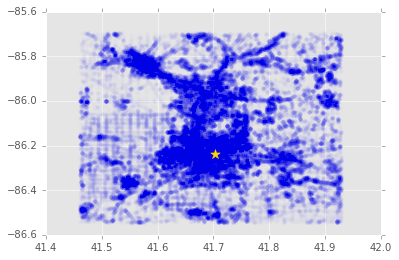

In [109]:
# plot locations
%matplotlib inline
plt.style.use('ggplot')
# all locations (blue dots)
plt.scatter(t1, t2, alpha=0.01)
# university of notre dame location (yellow star) 
plt.scatter(41.7030, -86.2390, color = "gold", marker = "*", s=100)

## Conclusions 

This analysis successfully cleaned various types of data (street names, street abbreviations, zip codes, county names, and road surfaces); however, the dataset is far from complete. Numerous other variables need to be audited and cleaned. Moreover, another major challenge is missing data. A significant number of nodes/ways are missing names, addresses, locations, and other tags. The data needs to be consistent in order to conduct any meaningful analysis. 

### Additional Ideas

During this analysis, I noticed that the majority of nodes/buildings on the campus of the University of Notre Dame, such as residence halls like Dillon Hall, were difficult to query for because "Notre Dame" wasn't explicitly in the name. Thus, I propose the creation of a "University Affiliation" tag that would contain this information. This tag would allow users of Open Street Map to easily identify University property. To accomplish this task, I could obtain a list of university buildings and manually add/edit the database; however, this would be inefficient and take a significant amount of time. Alternatively, I could do this programmatically by location data (latitude and longitude coordinates of the University's boundaries). This process could then be applied to other Universities across the country. 

Furthermore, I propose adding additional tags, such as housing values and business information, to the database. This data would allow us to produce interesting visualizations and identify trends. These additions could be made programmatically by parsing data from websites like Zillow and Yelp. This will be challenging due to differences in address/name formating between websites and the Open Street Map database. Nevertheless, the data can be cleaned programmatically and formatted consistently, as demonstrated in this report. 